## Implementation of the trading strategies with spike forecasting

We notice that on average the DART is positive (risk premium), so let run a  DART trading strategy with prediction of spikes

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from time import sleep
from utils import *
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier  # not used here, but you might need it elsewhere
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score



c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
USERNAME = 'tmaret@uchicago.edu'
PASSWORD = 'PowerMarket2025'
SUBSCRIPTION_KEY = '9f1e472b26a5439d84f564bf038e46fa' 

# Authorization URL for signing into ERCOT Public API account
AUTH_URL = f'https://ercotb2c.b2clogin.com/ercotb2c.onmicrosoft.com/B2C_1_PUBAPI-ROPC-FLOW/oauth2/v2.0/token\
?username={USERNAME}\
&password={PASSWORD}\
&grant_type=password\
&scope=openid+fec253ea-0d06-4272-a5e6-b478baeecd70+offline_access\
&client_id=fec253ea-0d06-4272-a5e6-b478baeecd70\
&response_type=id_token'

# Sign In/Authenticate
auth_response = requests.post(AUTH_URL)

# Retrieve access token
access_token = auth_response.json().get("access_token")
print(auth_response)

<Response [200]>


In [3]:
list_of_zones = ['HB_HOUSTON', 'HB_WEST', 'HB_SOUTH', 'HB_NORTH', 'HB_PAN']

## get the dart prices

In [4]:
da_data = pd.DataFrame()
for code in list_of_zones:
    lmp_da = pd.read_csv(f'C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/Power_Market-1/Data/da_lmp_{code}.csv')
    ## get hourly data
    lmp_da['deliveryDate'] = pd.to_datetime(lmp_da['deliveryDate'])
    lmp_da['hourEnding'] = lmp_da['hourEnding'].apply(lambda x: int(x.split(':')[0]))
    lmp_da = lmp_da.rename(columns={'settlementPointPrice': code+'_da', 'deliveryDate': 'date', 'hourEnding': 'hour'})[['date', 'hour', code+'_da']]
    if da_data.empty:
        da_data = lmp_da
    else:
        da_data = pd.merge(da_data, lmp_da, on=['date', 'hour'], how='outer')
da_data['date'] = pd.to_datetime(da_data['date'])

rt_data = pd.DataFrame()

for code in list_of_zones:
    lmp_rt = pd.read_parquet(f'C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/Power_Market-1/Data/rtm_LMP_{code}.parquet')
    ## get hourly data
    lmp_rt['SCEDTimestamp'] = pd.to_datetime(lmp_rt['SCEDTimestamp'])
    ## create a new df that aggregates all the LMPs for each hour : do equal weighted average
    lmp_rt['hour'] = lmp_rt['SCEDTimestamp'].dt.hour
    lmp_rt['date'] = lmp_rt['SCEDTimestamp'].dt.date

    rtm_hourly = lmp_rt.groupby(['date', 'hour'])['LMP'].mean().reset_index()
    rtm_hourly['date'] = pd.to_datetime(rtm_hourly['date'])

    rtm_hourly = rtm_hourly.rename(columns={'LMP': code+'_rt'})
    if rt_data.empty:
        rt_data = rtm_hourly
    else:
        rt_data = pd.merge(rt_data, rtm_hourly, on=['date', 'hour'], how='outer')
rt_data['date'] = pd.to_datetime(rt_data['date'])


## merge the two datasets
data = pd.merge(da_data, rt_data, on=['date', 'hour'], how='outer')
data = data.sort_values(by=['date', 'hour'])

## get da - rt spread
for code in list_of_zones:
    data[code+'_spread'] = data[code+'_da'] - data[code+'_rt']

dart_prices = data[['date', 'hour'] + [code+'_spread' for code in list_of_zones]]
dart_prices = dart_prices.dropna()

for code in list_of_zones:
    dart_prices[code +'_spike'] = dart_prices[code +'_spread'].apply(lambda x: 1 if x > 50 else (-1 if x < -50 else 0))
    ## rolling window of the last 96 hours to last 48 hours of the average of spike label
    st_spike_sum = dart_prices[code +'_spike'].rolling(48).sum()
    lt_spike_sum = dart_prices[code +'_spike'].rolling(96).sum()
    dart_prices[code +'_avg_last_spike'] = (lt_spike_sum - st_spike_sum)/48

dart_prices = dart_prices.dropna()


In [5]:
dart_prices.head()

,date,hour,HB_HOUSTON_spread,HB_WEST_spread,HB_SOUTH_spread,HB_NORTH_spread,HB_PAN_spread,HB_HOUSTON_spike,HB_HOUSTON_avg_last_spike,HB_WEST_spike,HB_WEST_avg_last_spike,HB_SOUTH_spike,HB_SOUTH_avg_last_spike,HB_NORTH_spike,HB_NORTH_avg_last_spike,HB_PAN_spike,HB_PAN_avg_last_spike
104,2024-01-05,4,-0.491667,-6.814167,1.786667,-0.919167,-0.569167,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
105,2024-01-05,5,1.623333,0.331667,3.894167,0.812500,0.719167,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
106,2024-01-05,6,2.408333,1.650833,5.210000,1.150833,0.847500,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
107,2024-01-05,7,6.595833,7.232500,7.430833,6.305000,6.510833,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
108,2024-01-05,8,8.812500,10.042500,8.362500,8.942500,9.422500,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


## Predictors

Load is realised values

Spot price does not need to be modeled

Weather are forecasts

In [22]:
start_date = '2024-01-01'
end_date = '2025-03-01'
# list_years = [2021, 2022, 2023, 2024, 2025]
# # Load data
# df_load = pd.DataFrame()
# for year in list_years:
#     # the file name is Native_Load_year.csv
#     file_name = '../Data/Hourly_Load_Data/Native_Load_' + str(year) + '.xlsx'
#     df_year = pd.read_excel(file_name)
#     df_load = pd.concat([df_load, df_year], axis=0)
    
# df_load['Hour Ending'] = pd.to_datetime(df_load['Hour Ending'], format='%m/%d/%Y %H:%M', errors='coerce')
# df_load = df_load.set_index('Hour Ending')

# mask = df_load.index.isnull()
# indices = np.where(mask)[0]
# index_list = list(df_load.index)

# for i in indices:
#     index_list[i] = index_list[i-1] + pd.DateOffset(hours=1)

# # Assign the new index to the DataFrame
# df_load.index = pd.Index(index_list)
# df_load = df_load[~df_load.index.duplicated(keep='first')][['ERCOT']] ## for now we will only use ERCOT as a predictor
# df_load = df_load.rename(columns={'ERCOT': 'load'})
# df_load['date'] = df_load.index.date
# df_load['date'] = pd.to_datetime(df_load['date'])
# df_load['hour'] = df_load.index.hour
# df_load = df_load.reset_index(drop=True)
# df_load.tail()

## download the forecasted load data
df_load = pd.read_parquet('C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/Power_Market-1/Data/forecasted_load.parquet')
## keep the forecast y_hat only and transform ds to date and hour
df_load = df_load.rename(columns={'ds': 'date', 'yhat': 'load'})[['date', 'load']]
df_load['date'] = pd.to_datetime(df_load['date'])
df_load['hour'] = df_load['date'].dt.hour
df_load['date'] = pd.to_datetime(df_load['date'].dt.date)
df_load



,date,load,hour
26084,2023-12-24,41533.803158,0
26085,2023-12-24,39157.496527,1
26086,2023-12-24,37246.850135,2
26087,2023-12-24,36037.229919,3
26088,2023-12-24,35648.698066,4
...,...,...,...
35127,2025-01-03,55462.525457,20
35128,2025-01-03,54022.783615,21
35129,2025-01-03,52026.736383,22
35130,2025-01-03,49625.266949,23


In [9]:

gas_spot_prices = pd.read_excel('../Data/NG_PRI_FUT_S1_D.xls', sheet_name='Data 1', skiprows=2)
gas_spot_prices = gas_spot_prices.set_index('Date')

# Keep values inside the date range
gas_spot_prices = gas_spot_prices.loc[start_date:end_date]

# Duplicate daily data into hourly data
hourly_data = []
for date, row in gas_spot_prices.iterrows():
    for hour in range(24):
        hourly_data.append([date + pd.Timedelta(hours=hour), row.values[0]])

hourly_gas_spot_prices = pd.DataFrame(hourly_data, columns=['Datetime', 'Price'])
hourly_gas_spot_prices = hourly_gas_spot_prices.set_index('Datetime')
gas_spot_prices = hourly_gas_spot_prices
gas_spot_prices = gas_spot_prices.rename(columns={'Price': 'gas_price'})
gas_spot_prices['date'] = gas_spot_prices.index.date
gas_spot_prices['date'] = pd.to_datetime(gas_spot_prices['date'])
gas_spot_prices['hour'] = gas_spot_prices.index.hour
gas_spot_prices = gas_spot_prices.reset_index(drop=True)
gas_spot_prices.head()

,gas_price,date,hour
0,2.56,2024-01-02,0
1,2.56,2024-01-02,1
2,2.56,2024-01-02,2
3,2.56,2024-01-02,3
4,2.56,2024-01-02,4


In [10]:
# get forecast weather data

df_wind_2024_forecast = pd.read_parquet("../Data/df_wind_2024_forecast.parquet")
df_solar_2024_forecast = pd.read_parquet("../Data/df_solar_2024_forecast.parquet")


## rename column to identify if solar or wind (add wind or solar for all columns) except date, and hour
df_wind_2024_forecast = df_wind_2024_forecast.add_suffix('_wind')
df_wind_2024_forecast = df_wind_2024_forecast.rename(columns={'deliveryDate_wind': 'date', 'hourEnding_wind': 'hour'})
df_wind_2024_forecast['date'] = pd.to_datetime(df_wind_2024_forecast['date'])
df_wind_2024_forecast = df_wind_2024_forecast.drop(columns=['postedDatetime_wind'])
df_solar_2024_forecast = df_solar_2024_forecast.add_suffix('_solar')
df_solar_2024_forecast = df_solar_2024_forecast.rename(columns={'deliveryDate_solar': 'date', 'hourEnding_solar': 'hour'})
df_solar_2024_forecast['date'] = pd.to_datetime(df_solar_2024_forecast['date'])
df_solar_2024_forecast = df_solar_2024_forecast.drop(columns=['postedDatetime_solar'])
df_wind_2024_forecast = df_wind_2024_forecast[['date', 'hour', 'STWPFSystemWide_wind']]
df_solar_2024_forecast = df_solar_2024_forecast[['date', 'hour', 'STPPFSystemWide_solar']]


display(df_wind_2024_forecast.head())
display(df_solar_2024_forecast.head())

## check if perfect multicollinearity between wind columns and solar columns
df_solar_2024_forecast.corr()

,date,hour,STWPFSystemWide_wind
1,2024-01-01,1,14949.6
2,2024-01-01,2,13614.3
3,2024-01-01,3,12387.0
4,2024-01-01,4,11400.4
5,2024-01-01,5,10127.2


,date,hour,STPPFSystemWide_solar
1,2024-01-01,1,0.0
2,2024-01-01,2,0.0
3,2024-01-01,3,0.0
4,2024-01-01,4,0.0
5,2024-01-01,5,0.0


,date,hour,STPPFSystemWide_solar
date,1.000000,-0.000186,0.068532
hour,-0.000186,1.000000,0.162246
STPPFSystemWide_solar,0.068532,0.162246,1.000000


## split dataset in train set and test set (trading part)

We train the first 6 month and start trading rigth after.

We will use this time forecasts as our features (to have a prediction model compared to the inference model that used the realised values)

For the forecasted load we will run a time series regression every week, same for the multi-nomial regression we the model every week

In [19]:
train_data = dart_prices[dart_prices['date'] <= mid_date]

dart_prices['date'] = pd.to_datetime(dart_prices['date'])
dart_prices['date'].dtype

dtype('<M8[ns]')

In [23]:
mid_date = '2024-06-01'
train_data = dart_prices[dart_prices['date'] <= mid_date]
train_data = pd.merge(train_data, df_load, on=['date', 'hour'], how='left')
train_data = pd.merge(train_data, gas_spot_prices, on=['date', 'hour'], how='left')
train_data = pd.merge(train_data, df_wind_2024_forecast, on=['date', 'hour'], how='left')
train_data = pd.merge(train_data, df_solar_2024_forecast, on=['date', 'hour'], how='left')
train_data = train_data.dropna()
display(train_data.tail())
min_trading_date = train_data['date'].min()
test_data = dart_prices[dart_prices['date'] >= mid_date]
test_data = pd.merge(test_data, df_load, on=['date', 'hour'], how='left')
test_data = pd.merge(test_data, gas_spot_prices, on=['date', 'hour'], how='left')
test_data = pd.merge(test_data, df_wind_2024_forecast, on=['date', 'hour'], how='left')
test_data = pd.merge(test_data, df_solar_2024_forecast, on=['date', 'hour'], how='left')
test_data = test_data.dropna()
display(test_data.head())


,date,hour,HB_HOUSTON_spread,HB_WEST_spread,HB_SOUTH_spread,HB_NORTH_spread,HB_PAN_spread,HB_HOUSTON_spike,HB_HOUSTON_avg_last_spike,HB_WEST_spike,...,HB_SOUTH_spike,HB_SOUTH_avg_last_spike,HB_NORTH_spike,HB_NORTH_avg_last_spike,HB_PAN_spike,HB_PAN_avg_last_spike,load,gas_price,STWPFSystemWide_wind,STPPFSystemWide_solar
3394,2024-05-31,19,8.267500,9.604167,6.662500,8.664167,9.058333,0,-0.062500,0,...,0,-0.104167,0,0.020833,0,0.020833,62474.026198,1.78,11259.2,8217.1
3395,2024-05-31,20,19.838333,23.279167,17.170833,21.739167,21.983333,0,-0.041667,0,...,0,-0.083333,0,0.020833,0,0.020833,61747.587190,1.78,11578.8,4370.9
3396,2024-05-31,21,45.217500,52.031667,42.133333,46.827500,46.295833,0,-0.020833,1,...,0,-0.062500,0,0.000000,0,0.020833,60415.185425,1.78,11882.9,404.5
3397,2024-05-31,22,31.845833,36.295833,30.915833,31.595833,29.915833,0,-0.020833,0,...,0,-0.041667,0,-0.020833,0,0.000000,58497.737205,1.78,12209.3,0.0
3398,2024-05-31,23,11.988333,15.398333,11.638333,11.668333,9.848333,0,-0.020833,0,...,0,-0.020833,0,-0.020833,0,-0.020833,56161.580595,1.78,12653.3,0.0


,date,hour,HB_HOUSTON_spread,HB_WEST_spread,HB_SOUTH_spread,HB_NORTH_spread,HB_PAN_spread,HB_HOUSTON_spike,HB_HOUSTON_avg_last_spike,HB_WEST_spike,...,HB_SOUTH_spike,HB_SOUTH_avg_last_spike,HB_NORTH_spike,HB_NORTH_avg_last_spike,HB_PAN_spike,HB_PAN_avg_last_spike,load,gas_price,STWPFSystemWide_wind,STPPFSystemWide_solar
46,2024-06-03,1,3.580833,-6.560000,2.035833,5.246667,-4.355000,0,-0.0625,0,...,0,-0.020833,0,-0.041667,0,-0.041667,52858.439961,2.55,24089.0,0.0
47,2024-06-03,2,2.830833,-3.779167,3.191667,5.252500,-2.458333,0,-0.0625,0,...,0,-0.020833,0,-0.041667,0,-0.041667,51138.970432,2.55,23915.8,0.0
48,2024-06-03,3,1.140833,1.088333,4.480000,5.793333,0.612500,0,-0.0625,0,...,0,-0.020833,0,-0.041667,0,-0.041667,50098.538861,2.55,23698.0,0.0
49,2024-06-03,4,0.453333,4.180000,5.564167,7.540833,0.693333,0,-0.0625,0,...,0,-0.020833,0,-0.041667,0,-0.041667,49865.908282,2.55,23579.4,0.0
50,2024-06-03,5,-1.460000,1.488333,2.695833,4.267500,-1.858333,0,-0.0625,0,...,0,-0.020833,0,-0.041667,0,-0.041667,50418.580146,2.55,23271.5,0.0


### Train data: from 2024-01-01 to 2024-06-01

this will serve to train a model that forecast spikes

In [24]:
## define a spike label column
train_data['month'] = train_data['date'].dt.month 
test_data['month'] = test_data['date'].dt.month
train_data['day_of_week'] = train_data['date'].dt.dayofweek
test_data['day_of_week'] = test_data['date'].dt.dayofweek
train_data['hour'] = train_data['hour'].astype('category')
test_data['hour'] = test_data['hour'].astype('category')
train_data['month'] = train_data['month'].astype('category')
test_data['month'] = test_data['month'].astype('category')
train_data['day_of_week'] = train_data['day_of_week'].astype('category')
test_data['day_of_week'] = test_data['day_of_week'].astype('category')

for code in list_of_zones:
    train_data[code +'_spike'] = train_data[code +'_spread'].apply(lambda x: 1 if x > 50 else (-1 if x < -50 else 0))
    test_data[code +'_spike'] = test_data[code +'_spread'].apply(lambda x: 1 if x > 50 else (-1 if x < -50 else 0))
    ## rolling window of the last 96 hours to last 48 hours of the average of spike label
    st_spike_sum = train_data[code +'_spike'].rolling(48).sum() ## short term
    lt_spike_sum = train_data[code +'_spike'].rolling(96).sum() ## long term
    train_data[code +'_avg_last_spike'] = (lt_spike_sum - st_spike_sum)/48
    
    st_spike_sum = test_data[code +'_spike'].rolling(48).sum() ## short term
    lt_spike_sum = test_data[code +'_spike'].rolling(96).sum() ## long term
    test_data[code +'_avg_last_spike'] = (lt_spike_sum - st_spike_sum)/48

display(train_data.describe())
display(test_data.describe())

,date,HB_HOUSTON_spread,HB_WEST_spread,HB_SOUTH_spread,HB_NORTH_spread,HB_PAN_spread,HB_HOUSTON_spike,HB_HOUSTON_avg_last_spike,HB_WEST_spike,HB_WEST_avg_last_spike,HB_SOUTH_spike,HB_SOUTH_avg_last_spike,HB_NORTH_spike,HB_NORTH_avg_last_spike,HB_PAN_spike,HB_PAN_avg_last_spike,load,gas_price,STWPFSystemWide_wind,STPPFSystemWide_solar
count,2343,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2248.000000,2343.000000,2248.000000,2343.000000,2248.000000,2343.000000,2248.000000,2343.000000,2248.000000,2343.000000,2343.000000,2343.000000,2343.000000
mean,2024-03-19 12:52:32.880921856,3.707509,4.949989,3.076454,4.094451,4.811927,0.005548,0.008230,0.002988,0.004671,0.002988,0.004671,0.006829,0.009119,0.012377,0.014921,47693.754098,2.007482,15232.254289,5277.448869
min,2024-01-05 00:00:00,-1536.003529,-1524.613529,-1504.816471,-1531.210000,-1529.528824,-1.000000,-0.250000,-1.000000,-0.187500,-1.000000,-0.270833,-1.000000,-0.187500,-1.000000,-0.166667,32950.335736,1.250000,311.300000,0.000000
25%,2024-02-12 00:00:00,-3.656667,-3.106667,-3.188333,-3.553750,-4.207083,0.000000,-0.020833,0.000000,-0.020833,0.000000,-0.020833,0.000000,-0.020833,0.000000,-0.020833,42887.702466,1.540000,9227.050000,0.000000
50%,2024-03-20 00:00:00,2.049167,3.215000,2.235000,2.163333,2.020769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47788.487175,1.670000,15269.900000,766.100000
75%,2024-04-25 00:00:00,7.980032,10.166667,7.952083,7.599583,9.425417,0.000000,0.020833,0.000000,0.020833,0.000000,0.020833,0.000000,0.020833,0.000000,0.041667,52666.124781,2.190000,21333.200000,11300.100000
max,2024-05-31 00:00:00,1806.578462,1882.021667,1795.089231,1868.623333,1866.793333,1.000000,0.479167,1.000000,0.562500,1.000000,0.416667,1.000000,0.520833,1.000000,0.562500,62699.517082,13.200000,32258.400000,19194.900000
std,NaN,88.338442,90.528913,84.798978,90.199225,90.544666,0.253858,0.085071,0.270195,0.092615,0.248805,0.081623,0.252985,0.084032,0.253617,0.087769,6864.670889,1.211979,7370.304540,6250.264881


,date,HB_HOUSTON_spread,HB_WEST_spread,HB_SOUTH_spread,HB_NORTH_spread,HB_PAN_spread,HB_HOUSTON_spike,HB_HOUSTON_avg_last_spike,HB_WEST_spike,HB_WEST_avg_last_spike,HB_SOUTH_spike,HB_SOUTH_avg_last_spike,HB_NORTH_spike,HB_NORTH_avg_last_spike,HB_PAN_spike,HB_PAN_avg_last_spike,load,gas_price,STWPFSystemWide_wind,STPPFSystemWide_solar
count,3358,3358.000000,3358.000000,3358.000000,3358.000000,3358.000000,3358.000000,3263.000000,3358.000000,3263.000000,3358.000000,3263.000000,3358.000000,3263.000000,3358.000000,3263.000000,3358.000000,3358.000000,3358.000000,3358.000000
mean,2024-09-15 17:45:12.328766976,1.061836,0.649592,1.195003,0.776395,1.254228,0.004467,0.005287,0.004169,0.005108,0.004765,0.005280,0.005956,0.006640,0.008338,0.009060,56915.338181,2.308151,11929.081090,6866.501102
min,2024-06-03 00:00:00,-2784.165714,-2749.602857,-2805.918571,-2765.710714,-2755.485714,-1.000000,-0.083333,-1.000000,-0.145833,-1.000000,-0.166667,-1.000000,-0.104167,-1.000000,-0.125000,39366.489745,1.210000,315.400000,0.000000
25%,2024-07-25 00:00:00,-3.281667,-4.536458,-2.849119,-3.748333,-4.687708,0.000000,0.000000,0.000000,-0.020833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51058.061354,2.000000,6025.475000,0.000000
50%,2024-09-16 12:00:00,0.498333,1.006250,0.880833,0.521250,0.160417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56648.436267,2.205000,10651.600000,1038.450000
75%,2024-11-07 00:00:00,5.774792,7.564792,5.954375,6.010288,7.856667,0.000000,0.020833,0.000000,0.020833,0.000000,0.020833,0.000000,0.020833,0.000000,0.020833,63687.586977,2.610000,17197.600000,15184.475000
max,2024-12-31 00:00:00,759.428333,739.709167,750.545000,766.330000,795.715833,1.000000,0.208333,1.000000,0.187500,1.000000,0.229167,1.000000,0.145833,1.000000,0.145833,73007.705730,3.400000,31279.600000,21515.200000
std,NaN,59.352440,60.702080,59.774661,59.787653,60.483444,0.169926,0.037063,0.198251,0.040138,0.185828,0.043144,0.179265,0.035640,0.198119,0.037488,8414.593142,0.453070,7131.212506,7868.618530


## Train Multinomial logistic regression

We are running rare event detection so we know that this creates an unbalanced dataset

In [ ]:

# Define predictors
predictors = ['day_of_week', 'month', 'hour', 'load', 'gas_price', 
              'STWPFSystemWide_wind', 'STPPFSystemWide_solar', 'HB_HOUSTON_avg_last_spike']

# Process training data
train_data_processed = train_data.copy().dropna()

# Create binary target: 1 if HB_HOUSTON_spike equals -1, else 0
train_data_processed['binary_label'] = (train_data_processed['HB_HOUSTON_spike'] == -1).astype(int)

# Use predictors directly (do not add a constant; LogisticRegression adds an intercept by default)
X = train_data_processed[predictors]
y = train_data_processed['binary_label']

# Balance data: upsample the positive class (where binary_label == 1) to match the number of negatives
df_negative = train_data_processed[train_data_processed['binary_label'] == 0]
df_positive = train_data_processed[train_data_processed['binary_label'] == 1]

df_positive_upsampled = resample(df_positive, 
                                 replace=True, 
                                 n_samples=3*len(df_positive), 
                                 random_state=42)

train_data_balanced = pd.concat([df_negative, df_positive_upsampled])

# Separate predictors and target from the balanced dataset
X_balanced = train_data_balanced[predictors]
y_balanced = train_data_balanced['binary_label']

# Scale features using StandardScaler
scaler = StandardScaler()
X_balanced_scaled = scaler.fit_transform(X_balanced)

# Define and evaluate the binary logistic regression model using cross-validation
model = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='l2', C=1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_balanced_scaled, y_balanced, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy (CV): %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

# Train the model on the balanced, scaled training data
model.fit(X_balanced_scaled, y_balanced)
print("Training Accuracy: %.3f" % model.score(X_balanced_scaled, y_balanced))

# Evaluate the model on the balanced training data
y_pred = model.predict(X_balanced_scaled)
print("Confusion Matrix:")
print(confusion_matrix(y_balanced, y_pred))
print("\nClassification Report:")
print(classification_report(y_balanced, y_pred))

# Compute AUC (for binary classification, use probabilities for the positive class)
y_probs = model.predict_proba(X_balanced_scaled)[:, 1]
auc = roc_auc_score(y_balanced, y_probs)
print("AUC Score: %.3f" % auc)


Mean Accuracy (CV): 0.970 (0.002)
Training Accuracy: 0.970
Confusion Matrix:
[[2180    0]
 [  68    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2180
           1       0.00      0.00      0.00        68

    accuracy                           0.97      2248
   macro avg       0.48      0.50      0.49      2248
weighted avg       0.94      0.97      0.95      2248

AUC Score: 0.761


c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [58]:

from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_predict, KFold

regions = ['HOUSTON', 'WEST', 'SOUTH', 'NORTH', 'PAN']

predictors = [
    'day_of_week', 'month', 'hour', 'load', 'gas_price',
    'STWPFSystemWide_wind', 'STPPFSystemWide_solar',
    *[f'HB_{region}_avg_last_spike' for region in regions]
]

train_data_processed = train_data.copy().dropna()

# Créer les cibles binaires pour toutes les régions
y = pd.DataFrame()
for region in regions:
    y[f'HB_{region}_spike'] = (train_data_processed[f'HB_{region}_spike'] == -1).astype(int)

X = train_data_processed[predictors]

# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Créer et entraîner le modèle multi-cibles
model = MultiOutputClassifier(
    LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        penalty='l2',
        C=1,
        class_weight='balanced'  # for imbalanced classes
    )
)

# Validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(model, X_scaled, y, cv=cv, method='predict_proba')

# Calcul des métriques pour chaque région
for i, region in enumerate(regions):
    region_probs = y_pred[i][:, 1]
    region_auc = roc_auc_score(y.iloc[:, i], region_probs)
    print(f"{region} - AUC: {region_auc:.3f}")

# Entraînement final sur toutes les données
model.fit(X_scaled, y)

# Rapport de classification global
print("\nRapport global:")
y_pred_full = model.predict(X_scaled)
print(classification_report(y, y_pred_full, target_names=regions))

HOUSTON - AUC: 0.757
WEST - AUC: 0.708
SOUTH - AUC: 0.739
NORTH - AUC: 0.736
PAN - AUC: 0.781

Rapport global:
              precision    recall  f1-score   support

     HOUSTON       0.07      0.74      0.14        68
        WEST       0.07      0.65      0.13        81
       SOUTH       0.07      0.76      0.13        68
       NORTH       0.07      0.74      0.13        66
         PAN       0.07      0.77      0.14        60

   micro avg       0.07      0.73      0.13       343
   macro avg       0.07      0.73      0.13       343
weighted avg       0.07      0.73      0.13       343
 samples avg       0.03      0.03      0.03       343



c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
y_test_pred_full = model.predict(test_data[predictors].dropna())
mask = test_data[predictors].dropna().index
regions_forecast_spike = ['HB_HOUSTON_spike_forecast', 'HB_WEST_spike_forecast', 'HB_SOUTH_spike_forecast', 'HB_NORTH_spike_forecast', 'HB_PAN_spike_forecast']
y_test_pred_full = pd.DataFrame(y_test_pred_full, columns=regions_forecast_spike, index=mask)

trading_data_set = pd.merge(test_data, y_test_pred_full, left_index=True, right_index=True, how='inner')
trading_data_set

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.w

,date,hour,HB_HOUSTON_spread,HB_WEST_spread,HB_SOUTH_spread,HB_NORTH_spread,HB_PAN_spread,HB_HOUSTON_spike,HB_HOUSTON_avg_last_spike,HB_WEST_spike,...,gas_price,STWPFSystemWide_wind,STPPFSystemWide_solar,month,day_of_week,HB_HOUSTON_spike_forecast,HB_WEST_spike_forecast,HB_SOUTH_spike_forecast,HB_NORTH_spike_forecast,HB_PAN_spike_forecast
141,2024-06-07,4,-6.761667,-17.405833,-7.805833,-5.686667,-7.084167,0,-0.083333,0,...,2.46,15607.3,0.0,6,4,1,0,1,1,0
142,2024-06-07,5,-7.314167,-14.593333,-7.652500,-6.831667,-7.731667,0,-0.083333,0,...,2.46,13904.4,0.0,6,4,1,0,1,1,0
143,2024-06-07,6,-3.401667,-6.522500,-2.879167,-3.752500,-4.227500,0,-0.083333,0,...,2.46,12572.4,0.0,6,4,1,0,1,1,0
144,2024-06-07,7,2.476667,0.925000,3.241667,2.181667,1.931667,0,-0.083333,0,...,2.46,11558.6,191.3,6,4,1,0,1,1,0
145,2024-06-07,8,1.028333,0.588333,2.008333,0.418333,0.348333,0,-0.083333,0,...,2.46,10153.3,3929.5,6,4,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4948,2024-12-31,19,5.110833,0.643333,6.040833,3.360833,1.141667,0,-0.041667,0,...,3.40,7046.4,0.0,12,1,1,0,1,1,0
4949,2024-12-31,20,6.673333,11.677500,3.783333,8.889167,10.493333,0,-0.041667,0,...,3.40,8725.6,0.0,12,1,1,0,1,1,0
4950,2024-12-31,21,7.878333,10.880000,5.632500,9.409167,10.270833,0,-0.041667,0,...,3.40,9964.6,0.0,12,1,1,0,1,1,0
4951,2024-12-31,22,2.580833,4.791667,1.283333,3.405833,4.084167,0,-0.041667,0,...,3.40,10942.7,0.0,12,1,1,0,1,1,0


## Test Multinomial Logistic regression

In [45]:
# Process test data: remove missing values
test_data_processed = test_data.copy().dropna()

# Select predictor features
x_test = test_data_processed[predictors]

# Create the binary target: 1 if HB_HOUSTON_spike == -1, else 0
y_test = (test_data_processed['HB_HOUSTON_spike'] == -1).astype(int)

# Scale test features using the scaler fitted on the training data
X_test_scaled = scaler.transform(x_test)

# Evaluate the model on the test set
test_accuracy = model.score(X_test_scaled, y_test)
print("Test Accuracy: %.3f" % test_accuracy)

# Get predictions and compute confusion matrix and classification report
y_pred = model.predict(X_test_scaled)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute AUC score for binary classification using predicted probabilities for the positive class (index 1)
y_probs = model.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_probs)
print("AUC Score: %.3f" % auc_score)


Test Accuracy: 0.186
Confusion Matrix:
[[ 573 2653]
 [   3   34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.18      0.30      3226
           1       0.01      0.92      0.02        37

    accuracy                           0.19      3263
   macro avg       0.50      0.55      0.16      3263
weighted avg       0.98      0.19      0.30      3263

AUC Score: 0.645


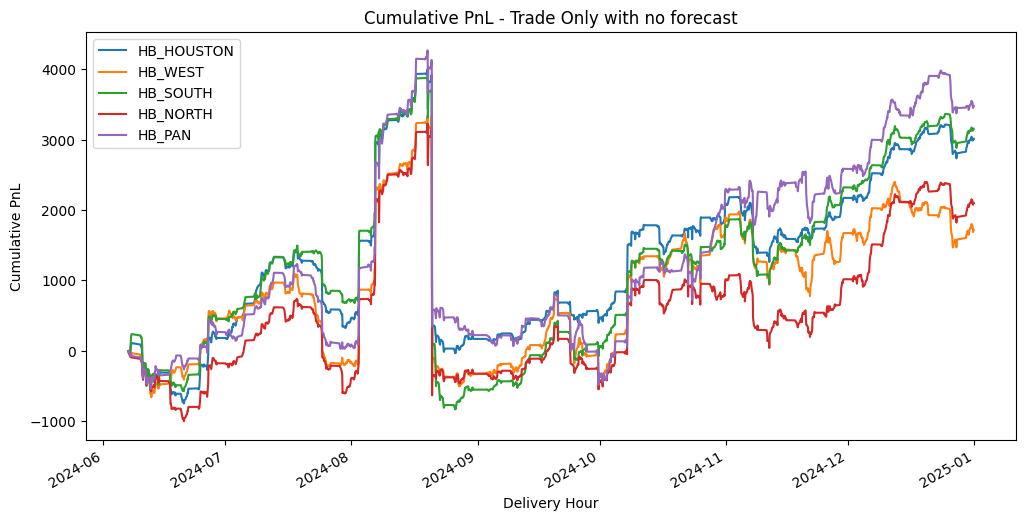

,HB_HOUSTON,HB_WEST,HB_SOUTH,HB_NORTH,HB_PAN
count,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000
mean,1320.703946,886.850715,1192.732113,560.631629,1359.714695
std,1120.075753,949.268187,1245.492902,967.608491,1311.304678
min,-750.411284,-660.409426,-833.368112,-1002.120630,-542.662370
25%,395.916407,-80.505830,97.272035,-255.880448,216.698627
50%,1348.862083,889.265762,1254.514796,418.499838,1001.584997
75%,1970.121611,1622.166186,1852.983521,939.436816,2386.170341
max,3997.370169,3338.787064,3883.249515,3228.633300,4269.810134


In [71]:
from datetime import timedelta

def backtest_advanced_trading_strategy(spread_data, list_of_zones):
    # Create a copy to avoid modifying original data
    df = spread_data.copy()
    
    # Convert date and hour to proper datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Convert hour from categorical to numeric
    df['hour'] = pd.to_numeric(df['hour'].astype(str))  # Handles categorical conversion
    
    # Create datetime index
    df['datetime'] = df['date'] + pd.to_timedelta(df['hour'], unit='h')
    
    # Create a DataFrame to store cumulative PnL for each zone
    results = pd.DataFrame(index=df.index)
    
    for zone in list_of_zones:
        # Create trading signal: 1 when forecast is 0, else 0
        trade_signal = (df[zone + '_spike_forecast'] == 0).astype(int)
        
        # Calculate hourly PnL
        results[zone] = (df[zone + '_spread'] * 1).cumsum()
    
    # Add datetime to results for plotting
    results['datetime'] = df['datetime']
    
    return results.set_index('datetime')

# Example usage:
list_of_zones = ['HB_HOUSTON', 'HB_WEST', 'HB_SOUTH', 'HB_NORTH', 'HB_PAN']
advanced_trading = backtest_advanced_trading_strategy(trading_data_set, list_of_zones=list_of_zones)

# Plot results
advanced_trading.plot(figsize=(12, 6))
plt.title('Cumulative PnL - Trade Only with no forecast')
plt.xlabel('Delivery Hour')
plt.ylabel('Cumulative PnL')
plt.show()

## print statistics
advanced_trading.describe()

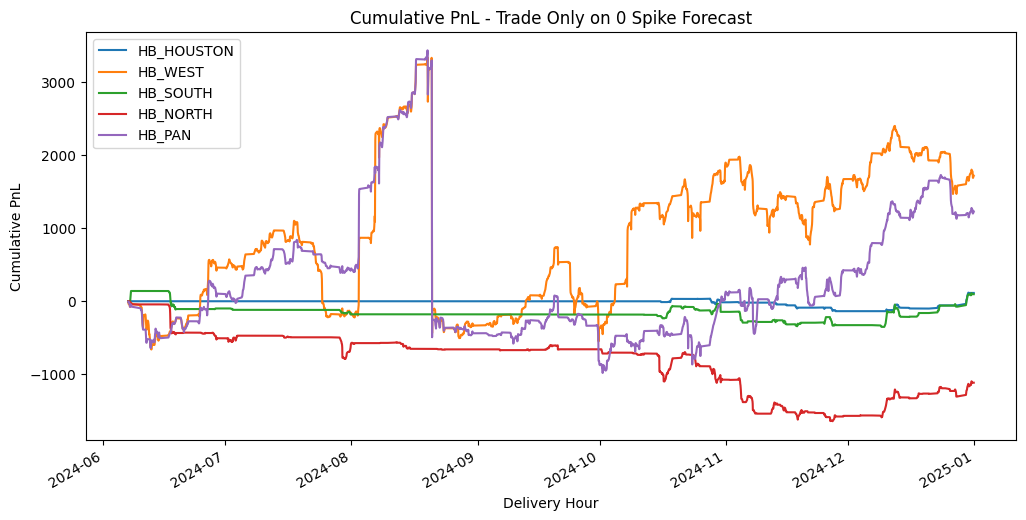


Trading Statistics:


,Total Return,Sharpe Ratio,Max Drawdown,Win Rate,Profit Factor,Total Trades,Winning Trades,Losing Trades,Avg Trade Return
Zone,,,,,,,,,
HB_HOUSTON,113.57,7.86,178.66,43.93%,1.26,214,94,120,0.5307
HB_WEST,"1,718.01",0.81,"3,888.04",54.73%,1.08,3263,1786,1477,0.5265
HB_SOUTH,96.26,1.71,491.19,50.00%,1.06,558,279,279,0.1725
HB_NORTH,"-1,114.96",-7.33,"1,642.41",48.79%,0.74,1072,523,549,-1.0401
HB_PAN,"1,227.98",0.65,"4,415.59",51.70%,1.07,2936,1518,1418,0.4182


In [77]:
from datetime import timedelta
import numpy as np
import pandas as pd
from math import sqrt

def backtest_advanced_trading_strategy(spread_data, list_of_zones):
    # Data preparation
    df = spread_data.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = pd.to_numeric(df['hour'].astype(str))
    df['datetime'] = df['date'] + pd.to_timedelta(df['hour'], unit='h')
    
    results = pd.DataFrame(index=df.index)
    stats = []
    
    for zone in list_of_zones:
        # Trading signals and returns
        trade_signal = (df[zone + '_spike_forecast'] == 0).astype(int)
        trade_returns = df[zone + '_spread'] * trade_signal
        
        # Store cumulative PnL
        results[zone] = trade_returns.cumsum()
        
        # Calculate statistics
        cumulative_pnl = trade_returns.cumsum()
        returns = trade_returns[trade_signal == 1]
        
        # Basic metrics
        total_trades = trade_signal.sum()
        total_return = cumulative_pnl.iloc[-1] if len(cumulative_pnl) > 0 else 0
        
        # Sharpe Ratio (annualized, assuming hourly data)
        sharpe = 0
        if len(returns) > 1:
            ann_factor = sqrt(24 * 365)  # Hourly data
            sharpe = (returns.mean() / returns.std()) * ann_factor
        
        # Max Drawdown
        running_max = cumulative_pnl.cummax()
        drawdown = (running_max - cumulative_pnl)
        max_drawdown = drawdown.max() if not drawdown.empty else 0
        
        # Win rate and profit factor
        winning_trades = (returns > 0).sum()
        losing_trades = (returns <= 0).sum()
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        gross_profit = returns[returns > 0].sum()
        gross_loss = abs(returns[returns <= 0].sum())
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
        
        stats.append({
            'Zone': zone,
            'Total Return': total_return,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_drawdown,
            'Win Rate': win_rate,
            'Profit Factor': profit_factor,
            'Total Trades': total_trades,
            'Winning Trades': winning_trades,
            'Losing Trades': losing_trades,
            'Avg Trade Return': returns.mean() if total_trades > 0 else 0
        })
    
    # Create statistics dataframe
    stats_df = pd.DataFrame(stats).set_index('Zone')
    
    return results.set_index(df['datetime']), stats_df

# Run backtest
cumulative_pnl, stats = backtest_advanced_trading_strategy(
    trading_data_set, 
    list_of_zones=['HB_HOUSTON', 'HB_WEST', 'HB_SOUTH', 'HB_NORTH', 'HB_PAN']
)

# Plot cumulative PnL
cumulative_pnl.plot(figsize=(12, 6))
plt.title('Cumulative PnL - Trade Only on 0 Spike Forecast')
plt.xlabel('Delivery Hour')
plt.ylabel('Cumulative PnL')
plt.show()

# Display statistics
print("\nTrading Statistics:")
display(stats.style.format({
    'Total Return': '{:,.2f}',
    'Sharpe Ratio': '{:.2f}',
    'Max Drawdown': '{:,.2f}',
    'Win Rate': '{:.2%}',
    'Profit Factor': '{:.2f}',
    'Avg Trade Return': '{:.4f}'
}))